In [1]:
!git clone https://github.com/scootie0129/Focusing-with-pseudo-bahtinov-mask/
!cp -r Focusing-with-pseudo-bahtinov-mask/data ./data

Cloning into 'Focusing-with-pseudo-bahtinov-mask'...
remote: Enumerating objects: 305, done.
remote: Counting objects: 100% (177/177), done.
remote: Compressing objects: 100% (134/134), done.
remote: Total 305 (delta 50), reused 157 (delta 38), pack-reused 128 (from 1)
Receiving objects: 100% (305/305), 943.03 MiB | 16.73 MiB/s, done.
Resolving deltas: 100% (71/71), done.
Updating files: 100% (171/171), done.


In [1]:
import tensorflow as tf
import keras

print(tf.__version__)
print(keras.__version__)

2.17.1
3.5.0


In [2]:
!nvidia-smi

Wed Dec 25 23:47:24 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)  # sets seeds for base-python, numpy and tf
tf.config.experimental.enable_op_determinism()

# 이미지 데이터 불러오기

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import pandas as pd

BATCH_SIZE = 8
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)

train_gen = ImageDataGenerator()
test_gen = ImageDataGenerator()
val_gen = ImageDataGenerator()

data_path = os.path.abspath('data')
train_path = os.path.join(data_path, 'train')
test_path = os.path.join(data_path, 'test')
validation_path = os.path.join(data_path, 'validation')

train_df = pd.read_csv(os.path.join(train_path, 'index.csv'))
test_df = pd.read_csv(os.path.join(test_path, 'index.csv'))
validation_df = pd.read_csv(os.path.join(validation_path, 'index.csv'))

train_flow_gen = train_gen.flow_from_dataframe(dataframe=train_df, directory=train_path, x_col='path', y_col='z', target_size=IMG_SIZE, class_mode='raw', batch_size=BATCH_SIZE, shuffle=True, seed=124)
val_flow_gen = val_gen.flow_from_dataframe(dataframe=validation_df, directory=validation_path, x_col='path', y_col='z', target_size=IMG_SIZE, class_mode='raw', batch_size=BATCH_SIZE, shuffle=True, seed=124)
test_flow_gen = test_gen.flow_from_dataframe(dataframe=test_df, directory=test_path, x_col='path', y_col='z', target_size=IMG_SIZE, class_mode='raw', batch_size=BATCH_SIZE, shuffle=True, seed=124)

Found 8 validated image filenames.
Found 8 validated image filenames.
Found 7 validated image filenames.


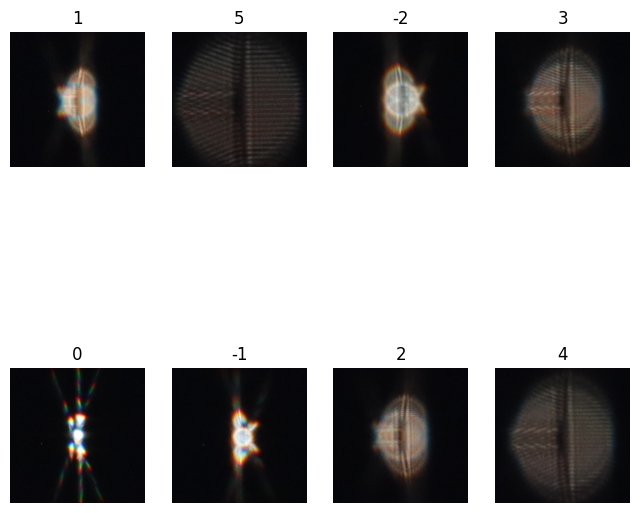

In [5]:
import matplotlib.pyplot as plt
import numpy as np

img, label = next(train_flow_gen)

plt.figure(figsize=(8, 8))
for i in range(8):
  ax = plt.subplot(2, 4, i+1)
  plt.imshow(img[i].astype(np.uint8))
  plt.title(label[i])
  plt.axis('off')

plt.show()

# 데이터 증강 레이어

In [6]:
from keras import Sequential, layers

data_aug = Sequential([
    layers.RandomFlip(),
    layers.RandomTranslation(0.2, 0.2, fill_mode='nearest'),
    layers.RandomRotation(1, fill_mode='nearest'),
    layers.RandomZoom(0.2, fill_mode='nearest'),
    layers.RandomContrast(0.2)
])

# ResNet152V2 기반 전이 학습 모델 구성

In [7]:
from keras.applications import resnet_v2

preprocess_input = resnet_v2.preprocess_input
base_model = resnet_v2.ResNet152V2(weights='imagenet', include_top=False, input_shape=IMG_SHAPE)

In [8]:
from keras import Input, Model

base_model.trainable = False

inputs = Input(shape=IMG_SHAPE)
x = data_aug(inputs)
x = preprocess_input(x)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1)(x)

model = Model(inputs, outputs)

In [9]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet152v2 (Functional)             │ (None, 7, 7, 2048)          │      58,331,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,333,697 (222.53 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 58,331,648 (222.52 MB)

In [10]:
from keras.optimizers import Adam, RMSprop
from keras.losses import mean_squared_error, mean_absolute_error

model.compile(optimizer=Adam(learning_rate=1e-4), loss=mean_squared_error, metrics=['mae'])

In [11]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [12]:
history = model.fit(train_flow_gen, epochs=30, validation_data=val_flow_gen, callbacks=[early_stopping])

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 27s 27s/step - loss: 8.5675 - mae: 2.5114 - val_loss: 6.9755 - val_mae: 2.0846
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - loss: 9.5203 - mae: 2.6457 - val_loss: 6.8695 - val_mae: 2.0682
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step - loss: 6.7837 - mae: 2.2778 - val_loss: 6.7674 - val_mae: 2.0531
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - loss: 5.5459 - mae: 2.0938 - val_loss: 6.6660 - val_mae: 2.0368
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 6.1345 - mae: 1.9925 - val_loss: 6.5687 - val_mae: 2.0219
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - loss: 6.2892 - mae: 2.0442 - val_loss: 6.4750 - val_mae: 2.0083
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - loss: 6.5992 - mae: 2.0813 - val_loss: 6.3820 - val_mae: 1.9939
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 5.9702 - mae: 1.9996 - val_loss: 6.2877 - val_mae: 1.9791
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - loss: 6.3756 - mae: 2.1885 - val

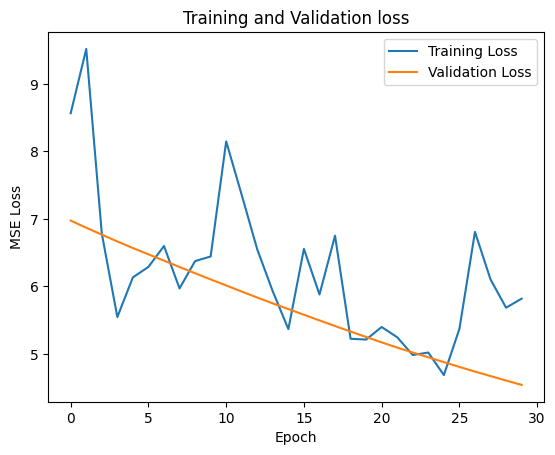

In [13]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.title('Training and Validation loss')
plt.show()

# 미세 조정(Fine-tuning)

In [14]:
base_model.trainable = True

for layer in base_model.layers[:-100]:
  layer.trainable = False

model.compile(optimizer=RMSprop(learning_rate=1e-4), loss=mean_squared_error, metrics=['mae'])

In [15]:
from keras.callbacks import ModelCheckpoint
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)

In [16]:
history_fine = model.fit(train_flow_gen, epochs=history.epoch[-1]+31, initial_epoch=history.epoch[-1]+1, validation_data=val_flow_gen, callbacks=[early_stopping, model_checkpoint])

Epoch 31/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 35s 35s/step - loss: 6.4379 - mae: 2.1715 - val_loss: 2.1218 - val_mae: 1.1349
Epoch 32/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 1.9754 - mae: 1.0101 - val_loss: 0.9078 - val_mae: 0.7423
Epoch 33/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - loss: 0.7479 - mae: 0.8464 - val_loss: 0.9340 - val_mae: 0.6996
Epoch 34/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - loss: 1.4463 - mae: 1.1307 - val_loss: 1.1573 - val_mae: 0.8278
Epoch 35/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step - loss: 0.7311 - mae: 0.7252 - val_loss: 1.0712 - val_mae: 0.7200
Epoch 36/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - loss: 0.3582 - mae: 0.4794 - val_loss: 1.1508 - val_mae: 0.7957
Epoch 37/60
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step - loss: 0.3929 - mae: 0.5318 - val_loss: 1.3874 - val_mae: 0.8899


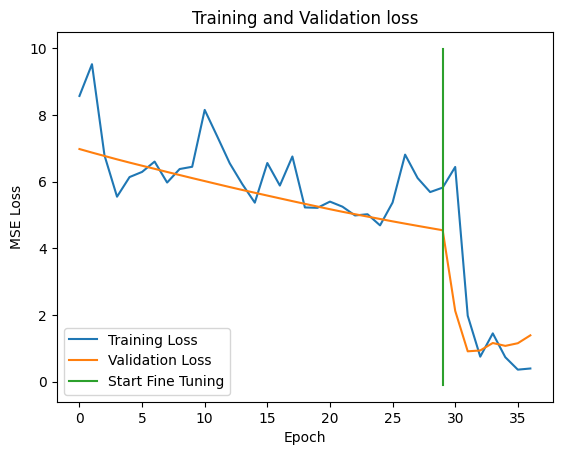

In [17]:
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([history.epoch[-1], history.epoch[-1]], plt.ylim(), label='Start Fine Tuning')
plt.legend()
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.title('Training and Validation loss')
plt.show()

model.save('fine_tuning.keras')

# 시험 세트를 이용한 평가

In [18]:
images, labels = next(test_flow_gen)
model.load_weights('best_model.keras')
pred = model.predict(images).reshape(-1)
np.set_printoptions(suppress=True)
print(f'Predicted: {pred}')
print(f'Actual: {labels}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted: [-1.1926012   3.7391288   0.5141162   2.1576111   0.01562286  3.9493873
  3.9561687 ]
Actual: [-1  4  1  2  0  3  5]


In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(f'MSE: {mean_squared_error(pred, labels)}, MAE: {mean_absolute_error(pred, labels)}')

MSE: 0.3367482125759125, MAE: 0.44368696212768555


Reference: [Transfer learning and fine-tuning](https://www.tensorflow.org/tutorials/images/transfer_learning)

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
!cp best_model.keras /content/drive/MyDrive